In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import arviz as az
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [2]:
# Parameters
a_sim = -2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0
epsilon = 1.0

In [3]:
# TVB model and integrator setup
oscillator_model = Generic2dOscillator(
    a=np.asarray([a_sim]),
    b=np.asarray([b_sim]),
    c=np.asarray([c_sim]),
    d=np.asarray([d_sim]),
    I=np.asarray([I_sim]),
)
oscillator_model.configure()

integrator = HeunStochastic(dt=0.1)
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [4]:
simulation_length = 100
stimulus = 0.0
local_coupling = 0.0

current_state_v = np.random.uniform(low=-2.0, high=4.0, size=[1, 1, 1])
current_state_w = np.random.uniform(low=-6.0, high=6.0, size=[1, 1, 1])
current_state = np.vstack([current_state_v, current_state_w])
state = current_state

current_step = 0
number_of_nodes = 1
start_step = current_step + 1
node_coupling = np.zeros([2, 1, 1])
n_steps = int(math.ceil(simulation_length / integrator.dt))

X = [current_state.copy()]
for step in range(start_step, start_step + n_steps):
    state = integrator.integrate(state, oscillator_model, node_coupling, local_coupling, stimulus)
    X.append(state.copy())

X = np.asarray(X)
t = np.linspace(0, simulation_length, n_steps + 1)

In [5]:
X_observed = np.random.normal(X, epsilon)

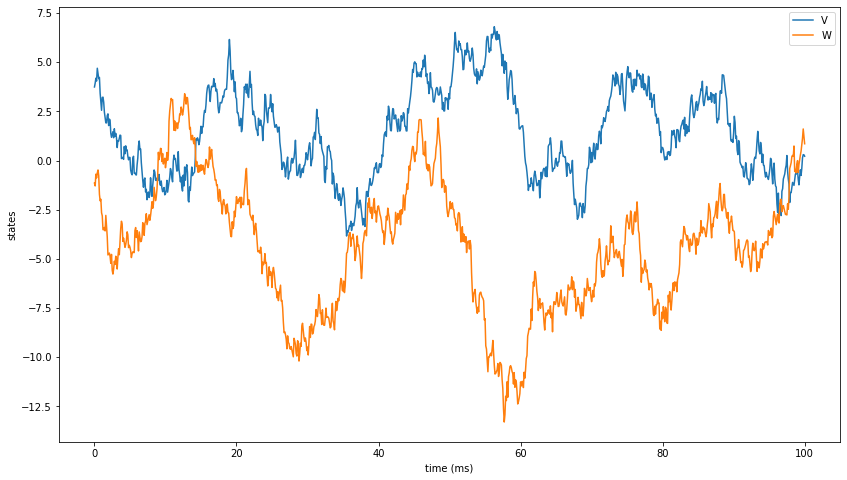

In [6]:
f1 = plt.figure(figsize=(14,8))
plt.plot(t, X[:, 0, 0, 0], label="V")
plt.plot(t, X[:, 1, 0, 0], label="W")
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.legend()
plt.show()

In [7]:
obs = {
    "x_obs": torch.distributions.MultivariateNormal(
        loc=torch.as_tensor(X.reshape(X.size, order="F")),
        scale_tril=torch.diag(torch.as_tensor(epsilon * np.ones(X.size)))
    ).sample()
}

priors = {
    "a": [-2.3, -1.7],
    "b": [-10.5, -9.5],
    "c": [-0.2, 0.2],
    "d": [0.01, 0.03],
    "I": [-0.2, 0.2],
    "epsilon": [0.9, 1.1]
}

In [8]:
from tvb.contrib.inversion.sbiInference import sbiModel

/Users/erichter/Documents/Uni/Charite/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


### SNPE inference

In [9]:
snpe_model = sbiModel(integrator, oscillator_model, obs, priors, X.shape)

In [11]:
snpe_model.run_inference(method="SNPE", 
                         num_simulations=800, 
                         num_workers=1, 
                         num_samples=2000)

Running 800 simulations.:   0%|          | 0/800 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
inference_data = snpe_model.to_arviz_data()

100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:01<00:00, 16.48it/s]


In [13]:
fn = snpe_model.inference_data.to_netcdf(filename = f"sbi_data/inference_data/{snpe_model.run_id}.nc", 
                                         compress=False)

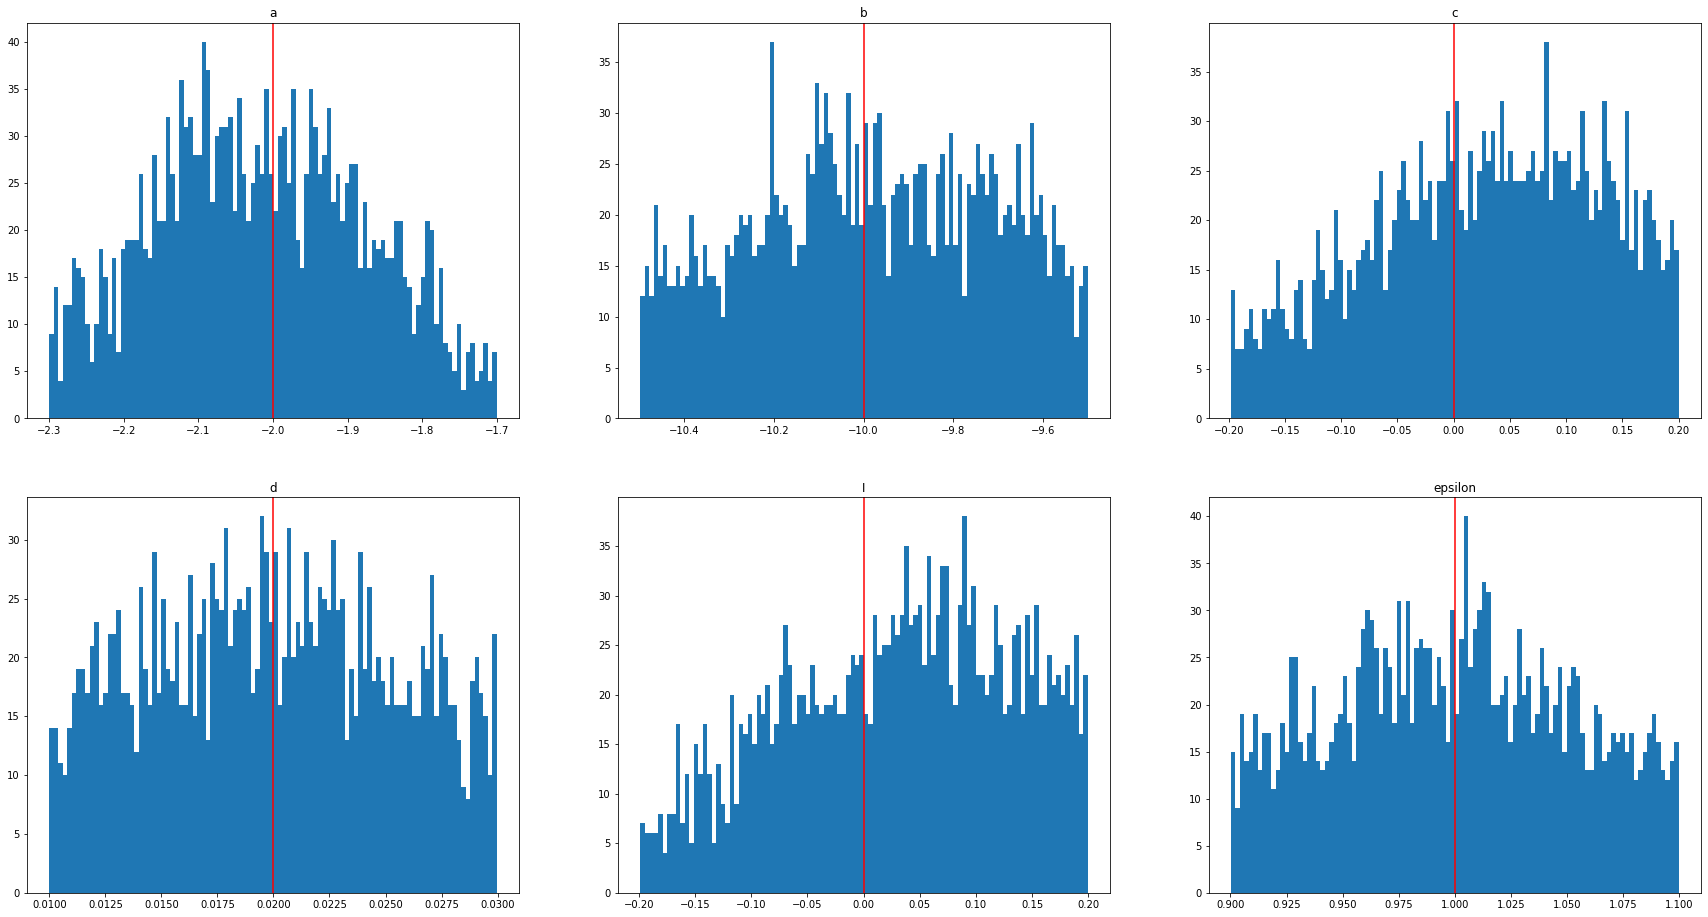

In [26]:
snpe_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": epsilon}
)

In [15]:
map_estimator = snpe_model.get_map_estimator()
map_estimator

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([-2.0372, -9.9324,  0.0655,  0.0199,  0.0563,  0.9931])

In [16]:
posterior_sample = snpe_model.get_sample()
posterior_sample

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-2.1334e+00, -9.9048e+00,  4.7678e-04,  1.8019e-02, -6.1247e-02,
          1.0810e+00]])

In [17]:
posterior_obs = snpe_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(X.shape, order="F")

In [18]:
#posterior_x_obs = snpe_model.inference_data.posterior_predictive.x_obs.values.reshape((2000, *X.shape))
#x_observed = snpe_model.inference_data.observed_data.x_obs.values

In [19]:
#f3 = plt.figure(figsize=(14,8))
#plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
#         "k", label=r"$V_{95\% PP}(t)$")
#plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
#         "k", label=r"$W_{95\% PP}(t)$")
#plt.plot(t, x_observed[:, 0, 0, 0], label="V_observed")
#plt.plot(t, x_observed[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
#plt.xlabel("time (ms)")
#plt.ylabel("states")
#plt.show()

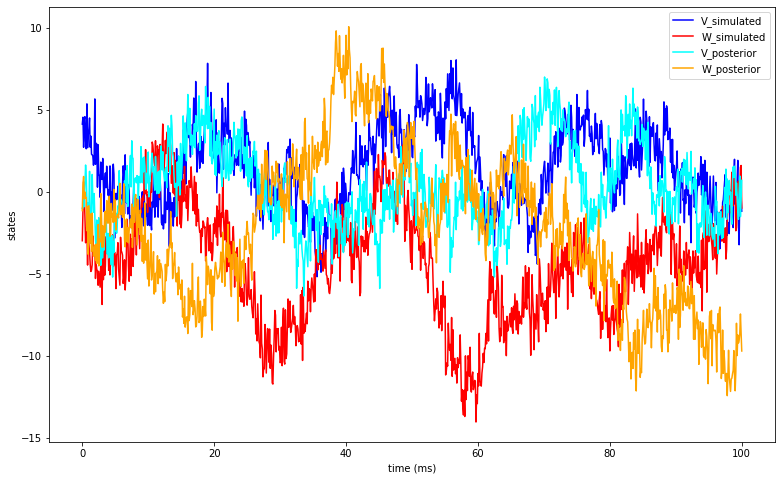

In [20]:
f3 = plt.figure(figsize=(13,8))
#plt.plot(observation["time"], observation["states"])
plt.plot(t, x_observed[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(t, x_observed[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(t, posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(t, posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [21]:
snpe_model.information_criteria()

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


{'WAIC': 7065.962822371861, 'LOO': 8109.806265964742}

### SNLE inference

In [ ]:
snle_model = sbiModel(integrator, oscillator_model, obs, priors)

In [ ]:
snle_model.run_inference(method="SNLE",
                         num_simulations=800,
                         num_workers=1,
                         num_samples=2000)

In [ ]:
snle_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "noise": sigma}
)

In [ ]:
map_estimator = snle_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snle_model.get_sample()
posterior_sample

In [ ]:
posterior_obs = snle_model.simulation_wrapper(params=map_estimator)

In [ ]:
f4 = plt.figure(figsize=(13,8))
#plt.plot(observation["time"], observation["states"])
plt.plot(t, X_observed[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(t, X_observed[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(t, posterior_obs[:len(X)], label="V_posterior", color="cyan")
plt.plot(t, posterior_obs[len(X):], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
inference_data = snle_model.to_arviz_data()

In [ ]:
snle_model.inference_data

In [ ]:
waic = az.waic(snle_model.inference_data, scale="deviance")
loo = az.loo(snle_model.inference_data, scale="deviance")

In [ ]:
waic.waic

In [ ]:
loo.loo

### SNRE inference

In [ ]:
snre_model = sbiModel(integrator, linear_model, obs, priors)

In [ ]:
snre_model.run_inference(method="SNRE",
                         num_simulations=800,
                         num_workers=1,
                         num_samples=1000)

In [ ]:
f2 = plt.figure(figsize=(13,8))
hx, hy, _ = plt.hist(np.asarray(snre_model.posterior_samples), bins=100);
plt.axvline(gamma, color="r", label=r"$\gamma$")
plt.show()

In [ ]:
map_estimator = snre_model.get_map_estimator()
map_estimator

In [ ]:
snre_model.density_estimator.eval()

In [ ]:
plt.plot(snre_model.log_prob.detach().numpy())

In [ ]:
posterior_sample = snre_model.get_sample()

In [ ]:
posterior_sample

In [ ]:
posterior_obs = snle_model.simulation_wrapper(params=map_estimator)

In [ ]:
f3 = plt.figure(figsize=(13,8))
#plt.plot(observation["time"], observation["states"])
plt.plot(t, X[:, 0, 0, 0])
plt.plot(t, posterior_obs)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
X_pp = snre_model.simulations_from_samples(n=1)

In [ ]:
mse = []
for sim in X_pp:
    mse.append(((X[:, 0, 0, 0] - sim) ** 2).mean())
mse = np.asarray(mse)

In [ ]:
samples[mse.argmin()]

In [ ]:
f4 = plt.figure(figsize=(13,8))
#plt.plot(observation["time"], observation["states"])
plt.plot(t, X[:, 0, 0, 0])
plt.plot(t, X_pp[mse.argmin()][:, 0, 0, 0])
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()